# YandexgGPT results in Centipede game

---



In [1]:
! pip3 install pymorphy3

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## YandexGPT (первый ход)

В этом случае YandexGPT ходит первым, а его оппонент постоянно 'пасует'. Таким образом можно узнать, когда YandexGPT забирает стопку себе (ничья также возможна).

In [3]:
df = pd.read_csv('solo_results_llm_first_move.csv')

In [4]:
df.shape

(2162, 6)

In [5]:
df.sample(5)

,game,round,player,emotional_state,action,explanation
1023,8b1ee524-0b8b-437a-be33-a4f1f2c1e3b0,3,Пользователь_1,нейтральный,take,"\n\nя выбираю «взять», потому что хочу получит..."
1486,48e8aa3f-d424-41c5-88a7-6485d78a5211,2,Пользователь_2,неважно,pass,без комментариев
2145,fa8599cc-a93c-4477-ae12-a23b4dfd13c4,5,Пользователь_1,нейтральный,pass,"\n\nпоскольку раунд близится к завершению, я в..."
1118,e1cd9f8e-0b6d-48e0-9c62-5cb435ef16a6,2,Пользователь_2,неважно,pass,без комментариев
579,8c01c7fd-98ca-4f34-acb0-12fed7b34850,6,Пользователь_2,неважно,pass,без комментариев


In [6]:
df['emotional_state'].unique()

array(['радостный', 'грустный', 'неважно', 'гневный', 'испуганный',
       'удивленный', 'злой', 'нейтральный'], dtype=object)

In [7]:
# Можем выкинуть эти строки, так как они не влияют на дальнейший анализ (по сути избавились от 2-го игрока)
df = df[df['emotional_state'] != 'неважно']

#### Число игр для каждого эмоционального состояния (проверить баланс классов)

In [8]:
games_per_emotional_state = df.groupby('emotional_state')['game'].nunique().reset_index()
games_per_emotional_state.columns = ['emotional_state', 'Number_of_Games']
print('Total number of games played: ', games_per_emotional_state['Number_of_Games'].sum())
games_per_emotional_state

Total number of games played:  661


,emotional_state,Number_of_Games
0,гневный,91
1,грустный,100
2,злой,100
3,испуганный,100
4,нейтральный,90
5,радостный,85
6,удивленный,95


#### Максимальное число раундов для каждого эмоционального состояния

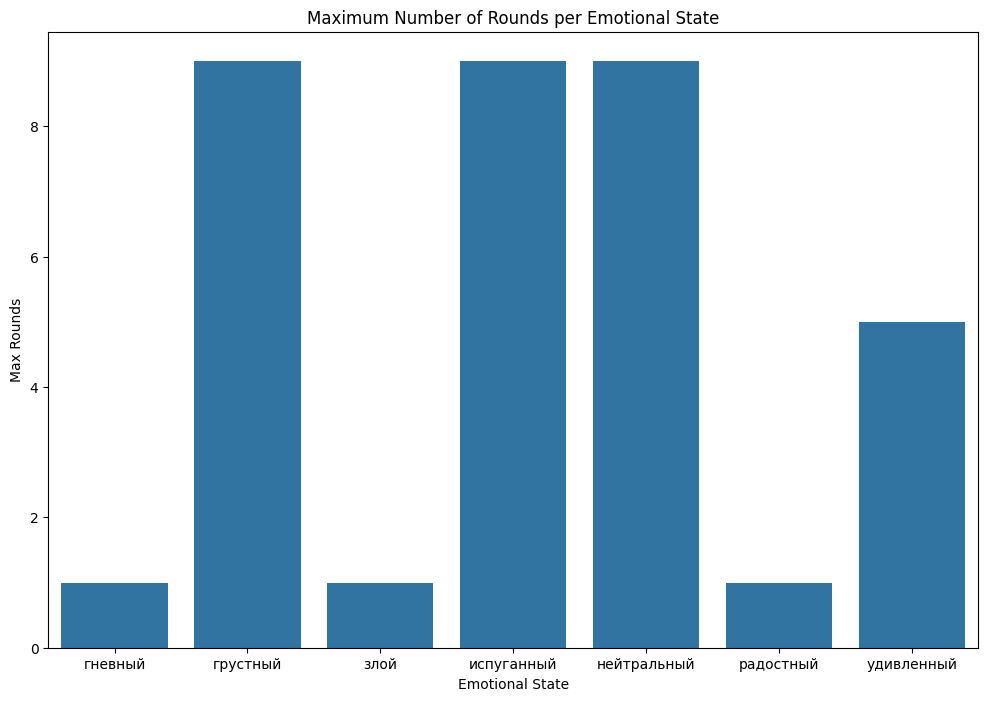

In [9]:
max_rounds_per_emotional_state = df.groupby('emotional_state')['round'].max().reset_index()
max_rounds_per_emotional_state.columns = ['emotional_state', 'max_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=max_rounds_per_emotional_state, x='emotional_state', y='max_round')
plt.title('Maximum Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Max Rounds')
plt.show()

#### Среднее число раундов для каждого эмоционального состояния

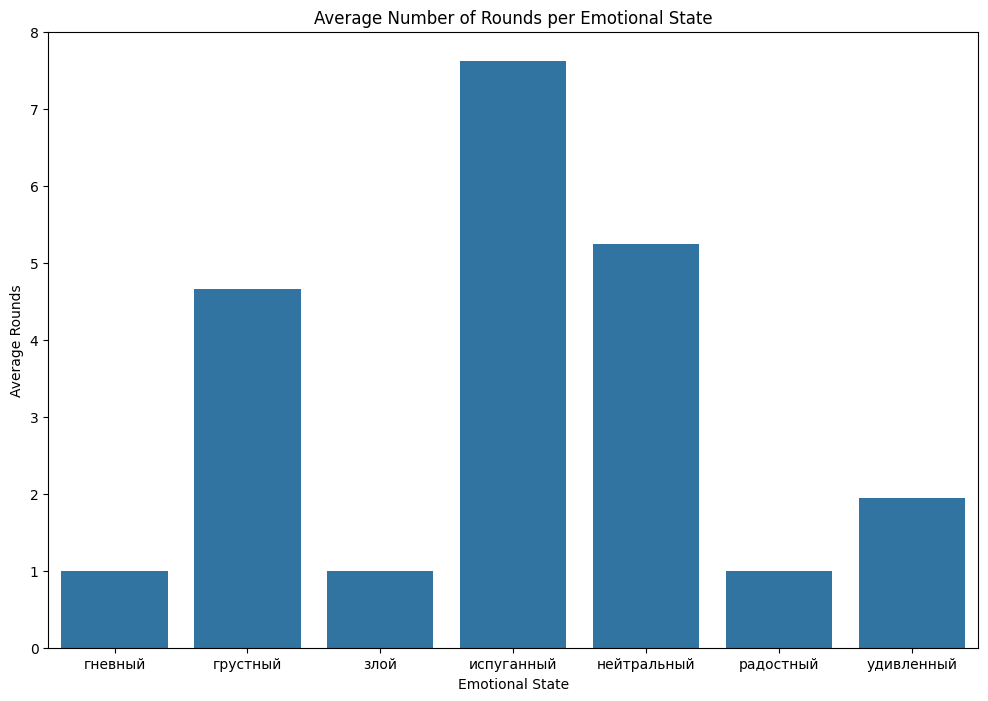

In [10]:
avg_rounds_per_emotional_state = df.groupby(['game', 'emotional_state'])['round'].max().reset_index().groupby(['emotional_state'])['round'].mean().reset_index()
avg_rounds_per_emotional_state.columns = ['emotional_state', 'avg_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_rounds_per_emotional_state, x='emotional_state', y='avg_round')
plt.title('Average Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Rounds')
plt.show()

In [11]:
avg_rounds_per_emotional_state

,emotional_state,avg_round
0,гневный,1.000000
1,грустный,4.660000
2,злой,1.000000
3,испуганный,7.620000
4,нейтральный,5.244444
5,радостный,1.000000
6,удивленный,1.947368


#### Анализ объяснений выбора YandexGPT

In [12]:
df_grouped = df.groupby('emotional_state')['explanation'].apply(lambda x: ' '.join(x)).reset_index()

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('russian') + ['это'])
morph = MorphAnalyzer()

def preprocess_text(text):
    text = text.lower()
    # Убираем пунктуацию и числа
    text = re.sub(r'\W+', ' ', text)

    words = text.split()
    words = [morph.normal_forms(word)[0] for word in words if word not in stop_words]
    return ' '.join(words)

df_grouped['cleaned_explanation'] = df_grouped['explanation'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_grouped['cleaned_explanation'])
cosine_similarities = cosine_similarity(X, X)

similarity_df = pd.DataFrame(cosine_similarities, index=df_grouped['emotional_state'], columns=df_grouped['emotional_state'])

def get_similar_emotional_states(similarity_df, threshold=0.5):
    similar_states = []
    for i in range(len(similarity_df)):
        for j in range(i+1, len(similarity_df)):
            if similarity_df.iloc[i, j] > threshold:
                similar_states.append((similarity_df.index[i], similarity_df.index[j], similarity_df.iloc[i, j]))
    return similar_states

similar_states = get_similar_emotional_states(similarity_df, threshold=0.81)

In [15]:
similar_states

[('грустный', 'нейтральный', 0.9053331581904615),
 ('грустный', 'удивленный', 0.8283420621207741),
 ('нейтральный', 'радостный', 0.8217218077311015),
 ('нейтральный', 'удивленный', 0.8718247384337245)]

#### Какие слова имеют наибольший tf-idf?

Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах.

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_grouped['cleaned_explanation'])

feature_names = vectorizer.get_feature_names_out()

tfidf_sums = X.sum(axis=0).A1

tfidf_df = pd.DataFrame({'term': feature_names, 'tfidf_sum': tfidf_sums})

tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

top_n = 15
top_terms = tfidf_df.head(top_n)

In [17]:
top_terms

,term,tfidf_sum
312,монета,3.180597
825,стопка,2.383819
711,раунд,1.821773
210,игра,1.589996
41,больший,1.235116
70,взять,1.217818
431,оппонент,1.088398
480,первый,0.975791
538,получить,0.938237
213,игрок,0.845248


## YandexGPT vs YandexGPT

В этом случае игрок и его оппонент есть YandexGPT (они являются независимыми игроками). Мы устанавливаем начальное эмоциональное состояние каждому игроку и смотрим как зависит уровень кооперации (число пройденных раундов) от эмоциональных состояний игроков. Важно, что сами игроки знают свое эмоциональное состояние и эмоциональное состояниие оппонента.

In [18]:
df = pd.read_csv('duo_results_llm_vs_llm.csv')

In [19]:
df.sample(5)

,game,round,player,emotional_state,action,explanation
1527,332e9e17-b2a2-4251-b2ed-0effb39f596d,1,Пользователь_1,"('нейтральный', 'грустный')",pass,\n\nпоскольку в начале игры у меня две стопки ...
1195,edefc37e-270c-4623-8b8d-54da5dfff1cd,4,Пользователь_2,"('удивленный', 'испуганный')",pass,\n\nиспуганный игрок может решить не рисковать...
174,5277b494-9f84-48e6-ac76-5a84383fd49a,1,Пользователь_1,"('радостный', 'злой')",take,"\n\nвыбор обусловлен тем, что радостный игрок ..."
1234,a8683108-7efb-48ab-8061-1813e2ac43a5,1,Пользователь_1,"('удивленный', 'удивленный')",take,"\n\nв данной ситуации, когда каждый игрок може..."
1395,6ff290e0-e4fc-4e92-a5a2-17f1ce245976,1,Пользователь_1,"('злой', 'испуганный')",take,\n\nв начале игры у игрока две стопки монет: 4...


#### Матрица максимального раунда для каждой пары эмоций

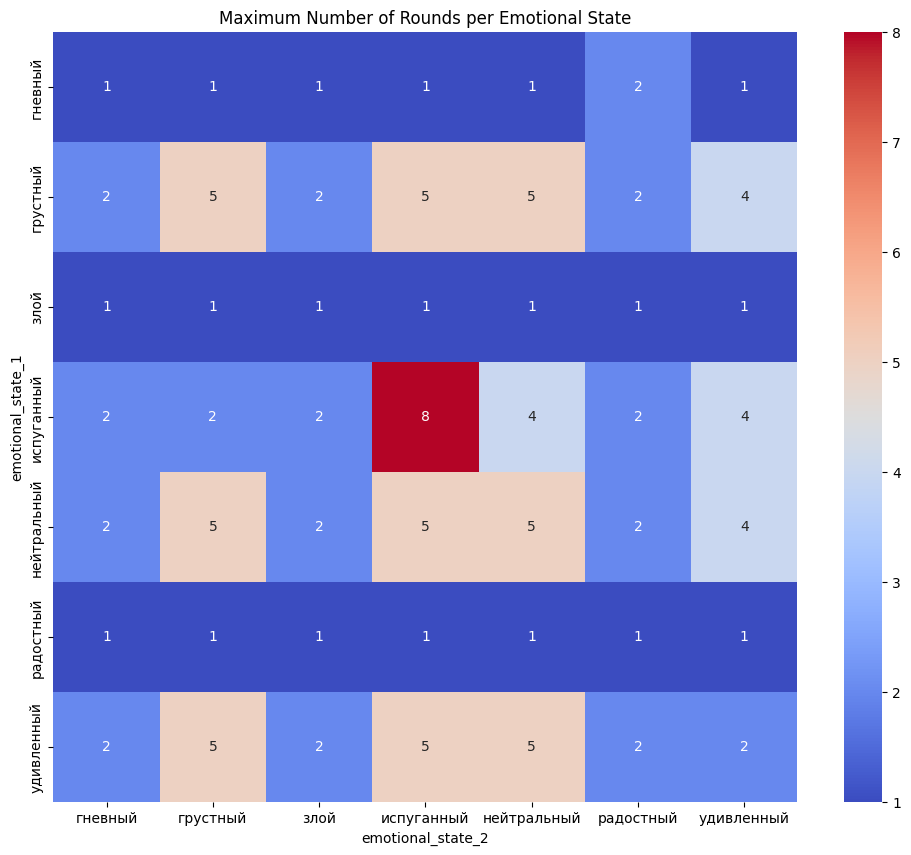

In [20]:
grouped = df.groupby('emotional_state')['round'].max().reset_index()
grouped.columns = ['emotional_state', 'max_round']

grouped['emotional_state_1'] = grouped['emotional_state'].apply(lambda x: x.split(',')[0][2:-1])
grouped['emotional_state_2'] = grouped['emotional_state'].apply(lambda x: x.split(', ')[1][1:-2])

matrix = grouped.pivot(index='emotional_state_1', columns='emotional_state_2', values='max_round')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.title('Maximum Number of Rounds per Emotional State')
plt.show()


#### Матрица среднего раунда для каждой пары эмоций

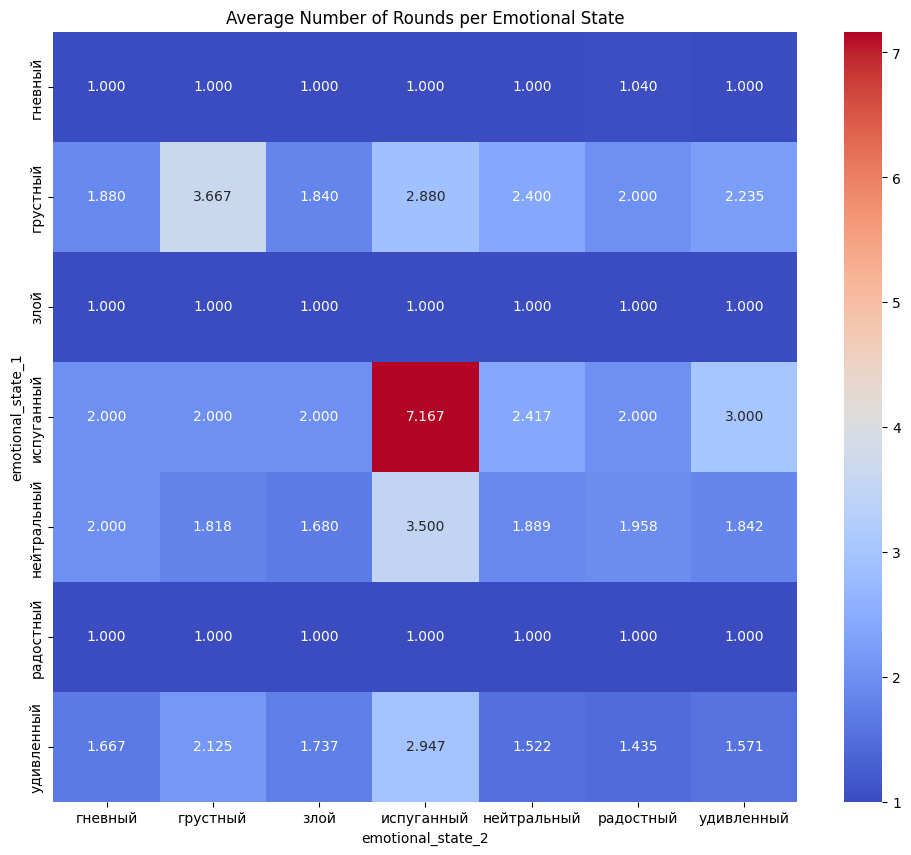

In [21]:
grouped = df.groupby(['game', 'emotional_state'])['round'].max().reset_index().groupby(['emotional_state'])['round'].mean().reset_index()
grouped.columns = ['emotional_state', 'avg_round']

grouped['emotional_state_1'] = grouped['emotional_state'].apply(lambda x: x.split(',')[0][2:-1])
grouped['emotional_state_2'] = grouped['emotional_state'].apply(lambda x: x.split(', ')[1][1:-2])

matrix = grouped.pivot(index='emotional_state_1', columns='emotional_state_2', values='avg_round')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Average Number of Rounds per Emotional State')
plt.show()

## YandexGPT (второй ход)

В этом случае YandexGPT ходит вторым, а его оппонент постоянно 'пасует'. В первом случае, когда YandexGPT ходил первым, при некоторых эмоциональных состояних он сразу забиирал себе большую стопку (на первом раунде). Изменится ли что-то здесь?

In [22]:
df = pd.read_csv('solo_results_second_move.csv')

In [23]:
df['emotional_state'] = df['emotional_state'].apply(lambda x: x.split(', ')[1][1:-2]) # взять второе название
games_per_emotional_state = df.groupby('emotional_state')['game'].nunique().reset_index()
games_per_emotional_state.columns = ['emotional_state', 'Number_of_Games']
print('Total number of games played: ', games_per_emotional_state['Number_of_Games'].sum())
games_per_emotional_state

Total number of games played:  733


,emotional_state,Number_of_Games
0,гневный,133
1,грустный,114
2,злой,85
3,испуганный,99
4,нейтральный,44
5,радостный,136
6,удивленный,122


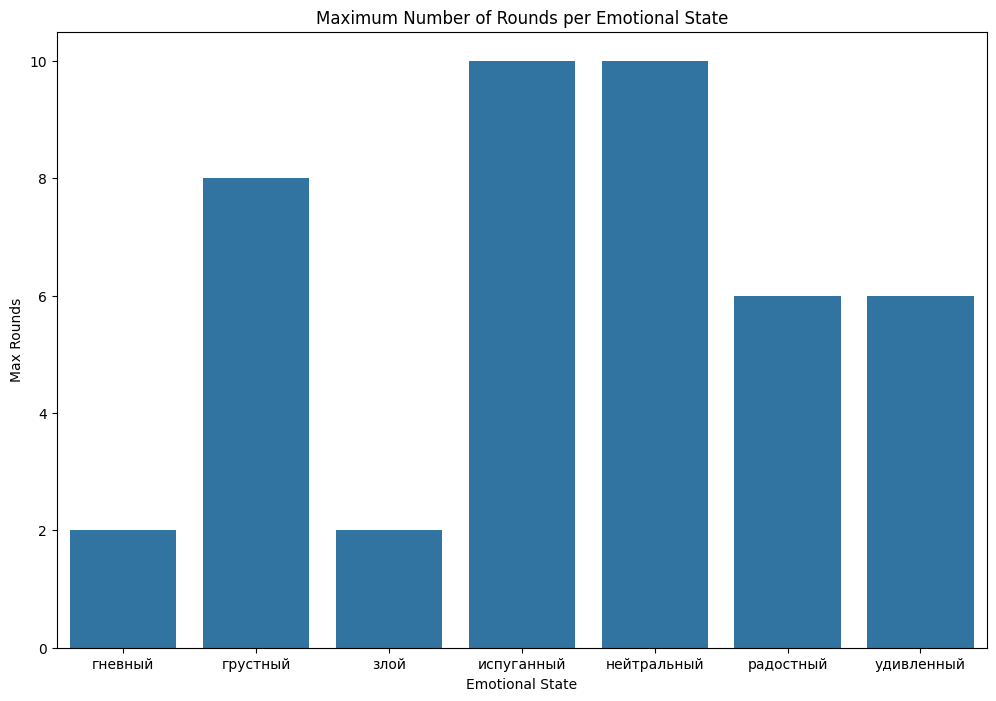

In [24]:
max_rounds_per_emotional_state = df.groupby('emotional_state')['round'].max().reset_index()
max_rounds_per_emotional_state.columns = ['emotional_state', 'max_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=max_rounds_per_emotional_state, x='emotional_state', y='max_round')
plt.title('Maximum Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Max Rounds')
plt.show()

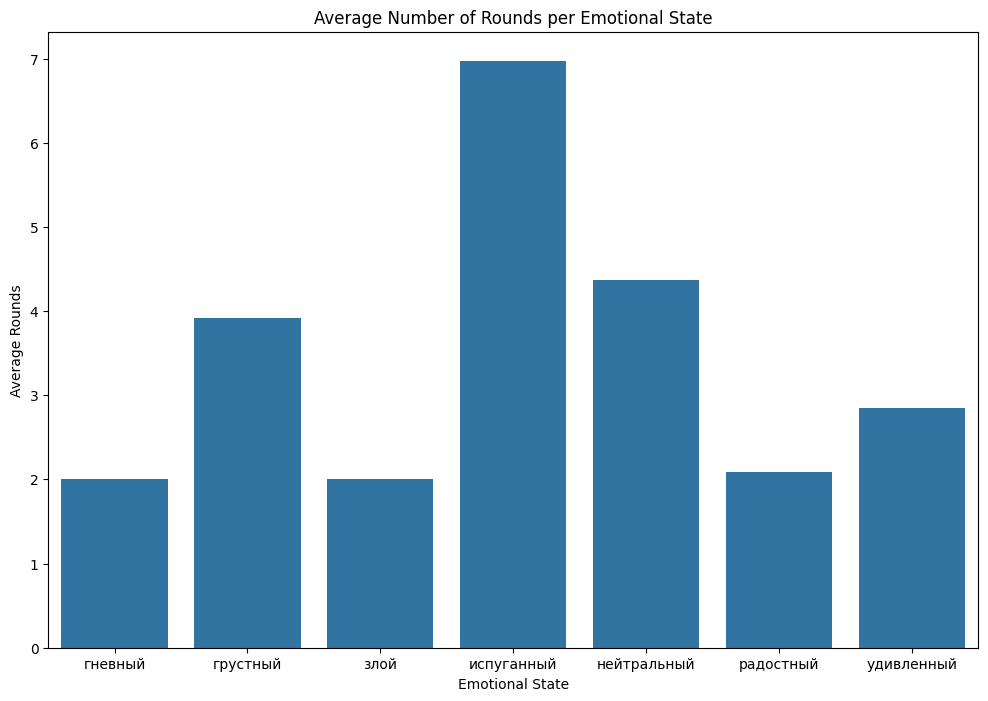

In [25]:
avg_rounds_per_emotional_state = df.groupby(['game', 'emotional_state'])['round'].max().reset_index().groupby(['emotional_state'])['round'].mean().reset_index()
avg_rounds_per_emotional_state.columns = ['emotional_state', 'avg_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_rounds_per_emotional_state, x='emotional_state', y='avg_round')
plt.title('Average Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Rounds')
plt.show()

In [26]:
avg_rounds_per_emotional_state

,emotional_state,avg_round
0,гневный,2.000000
1,грустный,3.912281
2,злой,2.000000
3,испуганный,6.969697
4,нейтральный,4.363636
5,радостный,2.088235
6,удивленный,2.852459
